In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.linear_model import LogisticRegression

from tools import Modelisation, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


Afin de comparer nos modèles en termes de performances brutes et de temps d'exécution, il est fondamental de déterminer quelques métriques de référence. Ici, il faut surtout faire en sorte d'éviter de prédire des non-clics qui seraient en réalité des clics (ie prédire trop de 0), quitte à prédire trop de 1. Autrement dit, il faut maximiser le recall et le NPV (Negative predictive value) afin de limiter les erreurs de type II. Le F1 Score, combinaison du recall et de la précision, est également pertinent. 

# Régression logistique
## Variables quantitatives

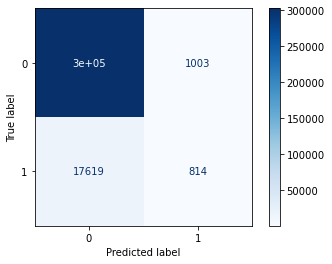

f1 : 0.0804
recall : 0.0442
negative predictive value : 0.9450
precision : 0.4480
roc_auc : 0.7402


In [4]:
m = Modelisation(X_quant, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

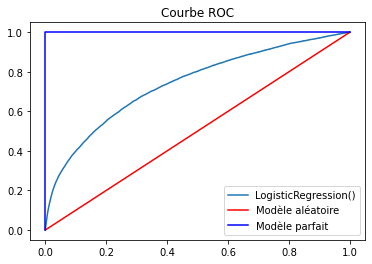

In [5]:
m.show_ROC()

In [6]:
coeff_df = pd.DataFrame(np.transpose(m.model.coef_), X_quant.columns, columns=['Coefficient'])
coeff_df

,Coefficient
contextid,-0.022778
campaignctrlast24h,0.359393
dayssincelastvisitdouble,-0.027930
ltf_nbglobaldisplay_4w,0.007898
ltf_nbpartnerdisplayssincelastclick,-0.020552
ltf_nbpartnerdisplay_90d,-0.013512
ltf_nbpartnerclick_90d,0.037300
ltf_nbpartnersales_90d,-0.008930
nbdayssincelastclick,-0.110443
nbdisplay_1hour,-0.222024


**Problème :** pas de scaling dans la cellule suivante

In [7]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X_ = add_constant(X_quant)
print(Logit(y, X_).fit().summary())

Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     is_display_clicked   No. Observations:              1610494
Model:                          Logit   Df Residuals:                  1610480
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Feb 2021   Pseudo R-squ.:                 0.09804
Time:                        17:09:34   Log-Likelihood:            -3.1747e+05
converged:                       True   LL-Null:                   -3.5198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7845      0.0

Avec LASSO (+ univariate mais variable déjà exclue par Lasso): 

In [8]:
X1 = df[['contextid',
         'zonecostineuro',
         'campaignctrlast24h',
         'ltf_nbpartnerclick_90d',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'nbdisplayglobalapprox_1d_sum_xdevice']]
y1 = df['is_display_clicked']

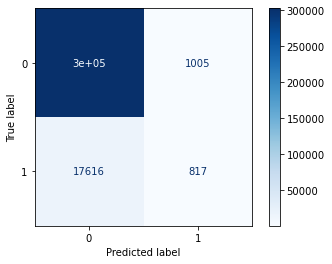

f1 : 0.0807
recall : 0.0443
negative predictive value : 0.9450
precision : 0.4484
roc_auc : 0.7401


In [9]:
m1 = Modelisation(X1, y1, LogisticRegression(), scaling=True)
m1.show_conf_matrix()
m1.show_metrics_score()

## Variables catégorielles

In [10]:
# Nombre de valeurs distinctes
from tools import COLUMNS_CAT
for column in COLUMNS_CAT:
    print(f"{column} : {len(set(df[column]))}")

display_env : 4
target_env : 2
campaignscenario : 7
campaignvertical : 34
is_interstitial : 3
device_type : 7
hour : 24
weekday : 7


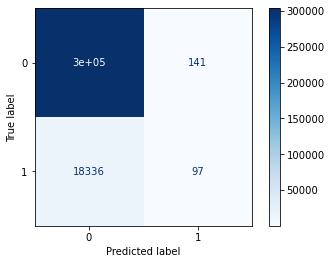

f1 : 0.0104
recall : 0.0053
negative predictive value : 0.9430
precision : 0.4076
roc_auc : 0.6876


In [11]:
m = Modelisation(X_cat, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

## Variables quantitatives + catégorielles

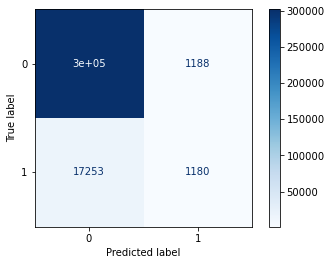

f1 : 0.1135
recall : 0.0640
negative predictive value : 0.9460
precision : 0.4983
roc_auc : 0.7569
Wall time: 10.8 s


In [12]:
%%time
m = Modelisation(X, y, LogisticRegression(), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

Avec RFECV :

In [13]:
X2 = X[['zonecostineuro',
         'campaignctrlast24h',
         'nbdisplay_1hour',
         'nbdayssincelastclick',
         'display_size',
         'is_interstitial_True',
         'device_type_Desktop',
         'device_type_iPhone',
         'display_env_app_ios',
         'target_env_2',
         'campaignscenario_13']]
y2 = df['is_display_clicked']

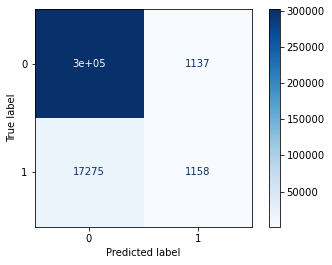

f1 : 0.1117
recall : 0.0628
negative predictive value : 0.9460
precision : 0.5046
roc_auc : 0.7534
Wall time: 3.15 s


In [14]:
%%time
m2 = Modelisation(X2, y2, LogisticRegression(), scaling=True)
m2.show_conf_matrix()
m2.show_metrics_score()

## Comparaison par rapport aux valeurs de C 

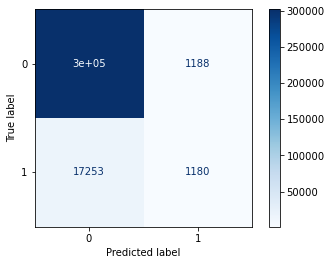

f1 : 0.1135
recall : 0.0640
negative predictive value : 0.9460
precision : 0.4983
roc_auc : 0.7569


In [15]:
m = Modelisation(X, y, LogisticRegression(C=0.2), scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

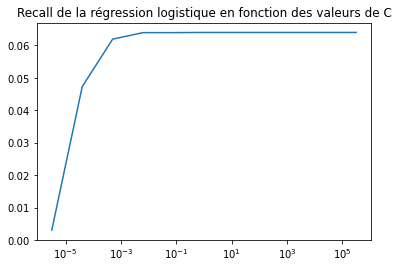

Wall time: 1min 36s


In [16]:
%%time
C, list_recall = [], []
for c in np.logspace(-5.5, 5.5, num=11): 
    m = Modelisation(X, y, LogisticRegression(C=c), scaling=True)
    C.append(c)
    list_recall.append(m.recall)
plt.plot(C, list_recall)
plt.xscale('log')
plt.title("Recall de la régression logistique en fonction des valeurs de C")
plt.show()

## Régression logistique sur la base sur-échantillonnée

**/!\ : Seule la base de training est sur-échantillonnée.**

In [17]:
df_train_res = pd.read_csv('data/df_train_res.csv').sample(frac=1)
print(df_train_res.shape)

(2419276, 22)


In [23]:
df_test_res = pd.read_csv('data/df_test_res.csv').sample(frac=1)
print(df_test_res.shape)

(320711, 22)


In [19]:
datasets_df_train_res = datasets(df_train_res, verbose=False)
X_quant_train_res = datasets_df_train_res['X_quant']
X_cat_train_res = datasets_df_train_res['X_cat']
X_train_res = datasets_df_train_res['X']
y_train_res = datasets_df_train_res['y']

In [20]:
datasets_df_test_res = datasets(df_test_res, verbose=False)
X_quant_test_res = datasets_df_test_res['X_quant']
X_cat_test_res = datasets_df_test_res['X_cat']
X_test_res = datasets_df_test_res['X']
y_test_res = datasets_df_test_res['y']

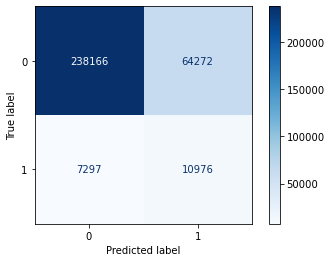

f1 : 0.2347
recall : 0.6007
negative predictive value : 0.9703
precision : 0.1459
roc_auc : 0.7550
Wall time: 18.3 s


In [21]:
%%time
m = Modelisation(X_train_res, y_train_res, LogisticRegression(), X_test=X_test_res, y_test=y_test_res, scaling=True)
m.show_conf_matrix()
m.show_metrics_score()

In [22]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:03:23
